In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
from datasets import *
from nets import *
from configs import *
from random import shuffle
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from datasets import *

In [3]:
from nets import *

In [4]:
class args:
    batch=32
    history=32
    numsegments=10
    hidden=256
    lr=0.0005
    epochs=120
    maxnodes=10

In [5]:
dataset, train_refs, test_refs = create_dataset_knodes(
    max_nodes=args.maxnodes,
    data_version=create_dataset_knodes_sensorid_v2)

In [6]:
len(train_refs)

94238

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
model = Series(
    batchsize=args.batch,
    historylen=args.history,
    numsegments=args.numsegments * 3 + 1,
    hiddensize=args.hidden,
    deepout=True
).to(device).double()

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [10]:
for eii in range(args.epochs):
    shuffle(train_refs)
    losses = []
    nBatches = len(train_refs)//args.batch
    for bii in range(0, len(train_refs) - args.batch, args.batch):
        model.train()
        
        batch_refs = train_refs[bii:bii+args.batch]
        batch_seq, batch_lbls = knodes_batch(dataset, batch_refs)
        
        batch_seq = np.transpose(batch_seq, [2, 0, 1])
        batch_seq = Variable(torch.from_numpy(batch_seq), requires_grad=True) \
            .to(device).double()
        batch_lbls = torch.from_numpy(batch_lbls).unsqueeze(2).to(device)

        lstm_state = model.init_lstms(device=device)

        preds, _ = model(batch_seq, lstm_state)

        loss = criterion(preds, batch_lbls)
        losses.append(loss.item())
        n_iter = eii*(nBatches)+bii
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sys.stdout.write('[E:%d/%d] B:%d/%d  loss: %.2f          \r' % (
            eii+1, args.epochs,
            bii//args.batch+1, nBatches,
            loss.item() * 100.0**2,
        ))
        sys.stdout.flush()
        
    nBatches = len(test_refs)//args.batch
    tloss = 0
    tmape = 0
    print()
    for bii in range(0, len(test_refs) - args.batch, args.batch):
        model.eval()
        
        batch_refs = test_refs[bii:bii+args.batch]
        batch_seq, batch_lbls = knodes_batch(dataset, batch_refs, mode='test')
        
        batch_seq = np.transpose(batch_seq, [2, 0, 1])
        batch_seq = Variable(torch.from_numpy(batch_seq), requires_grad=True) \
            .to(device).double()
        batch_lbls = torch.from_numpy(batch_lbls).unsqueeze(2).to(device)

        lstm_state = model.init_lstms(device=device)

        preds, _ = model(batch_seq, lstm_state)
        loss = criterion(preds, batch_lbls)
        tloss += loss.detach().cpu().numpy()
        
        batch_lbls = batch_lbls.detach().squeeze().cpu().numpy()
        preds = preds.detach().squeeze().cpu().numpy()
        batch_lbls[batch_lbls == 0] = 0.01
        tmape += np.mean(np.abs((preds - batch_lbls) / batch_lbls))
        
        sys.stdout.write('Testing %d/%d       \r' % (
            bii//args.batch+1, nBatches
        ))
#         break
    
    tmape /= nBatches
    tmape *= 100.0
    tloss /= nBatches
    print('   Testing Loss:  %.3f      Testing MAPE: %.1f%%' % (
        tloss * 100.0**2, tmape))

[E:1/120] B:2944/2944  loss: 1673.34           
   Testing Loss:  1389.413      Testing MAPE: 51.2%
[E:2/120] B:2944/2944  loss: 454.21            
   Testing Loss:  1430.975      Testing MAPE: 47.7%
[E:3/120] B:2944/2944  loss: 488.99            
   Testing Loss:  1378.217      Testing MAPE: 59.1%
[E:4/120] B:2944/2944  loss: 1569.99           
   Testing Loss:  1384.240      Testing MAPE: 53.2%
[E:5/120] B:2944/2944  loss: 288.99            
   Testing Loss:  1407.734      Testing MAPE: 61.1%


KeyboardInterrupt: 

In [20]:
def knearest(kk):
    _, (test_series, test_labels) = create_dataset_knodes_sensorid_v2(
        LIDS[3], kk, split=0.8)

    model.eval()
    series_loss = 0
    series_mape = 0
    continuous = []
    missing = 0
    lstm_state = model.init_lstms(device=device, batch=1)
    for ind in range(test_series.shape[1]):
        raw_batch_seq = np.array([test_series[:, ind:ind+1]])
        batch_seq = np.zeros((1, 10 * 3, 1))
        batch_seq[:, :raw_batch_seq.shape[1], :] = raw_batch_seq
        batch_lbls = np.array([[test_labels[ind]]])

    #     print(batch_seq.shape, batch_lbls.shape)

        batch_seq = np.transpose(batch_seq, [2, 0, 1])
        batch_seq = Variable(torch.from_numpy(batch_seq), requires_grad=False) \
            .to(device).double()
        batch_lbls = torch.from_numpy(batch_lbls).unsqueeze(2).to(device)

        preds, lstm_state = model(batch_seq, lstm_state)

        predval = preds.detach().squeeze().cpu().numpy()
        continuous.append(predval)

        if np.isnan(batch_lbls.item()):
            continue

        loss = criterion(preds, batch_lbls)
        series_loss += loss.detach().cpu().numpy()
        batch_lbls = batch_lbls.detach().squeeze().cpu().numpy()
        batch_lbls[batch_lbls == 0] = 0.01
        preds = preds.detach().squeeze().cpu().numpy()
        ape = np.abs((preds - batch_lbls) / batch_lbls)
    #     print(ape, preds, batch_lbls)
        series_mape += ape
    series_loss /= (test_series.shape[1] - missing)
    series_mape /= (test_series.shape[1] - missing)
    series_mape *= 100.0
    series_loss *= 100**2

    
    plt.gca().set_title('K: %d  MSE: %.2f   MAPE: %.2f' % (kk+1, series_loss, series_mape))
    for ii in range(kk):
        plt.plot(test_series[3*ii, :] * 100, color='#AAAAAA')
    plt.plot(np.array(continuous) * 100)
    plt.plot(np.array(test_labels) * 100)
    plt.show();plt.close()

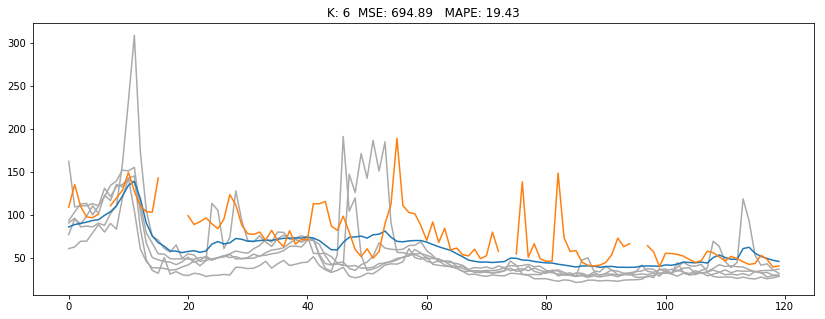

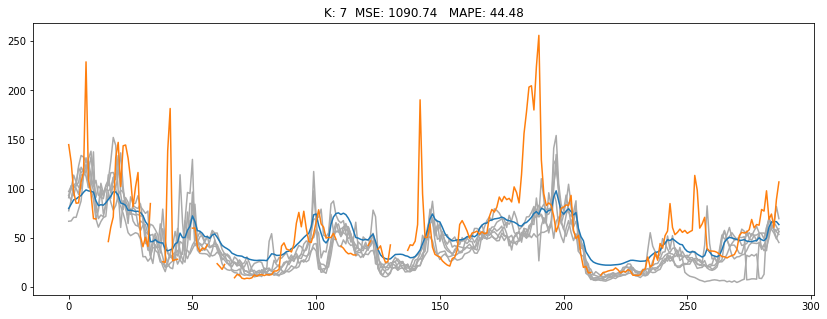

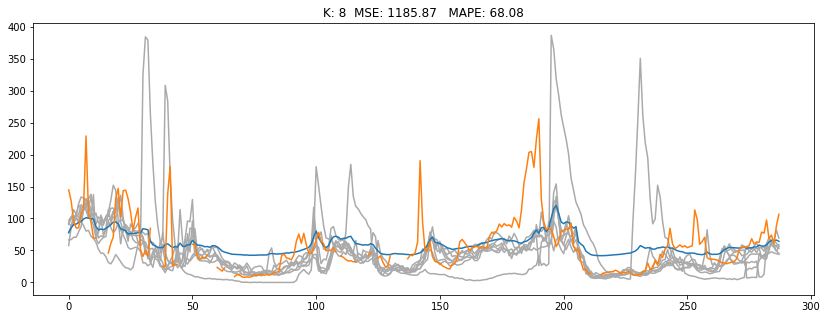

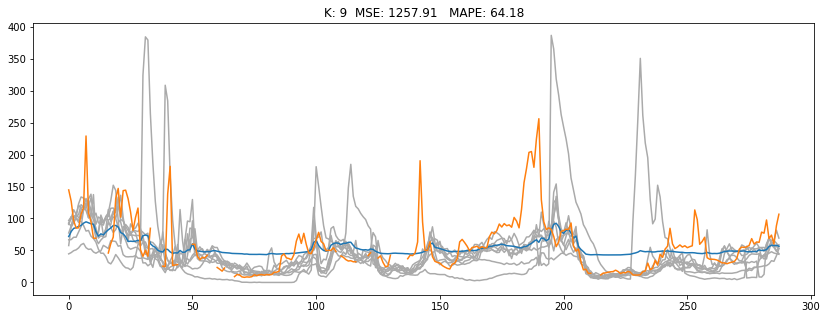

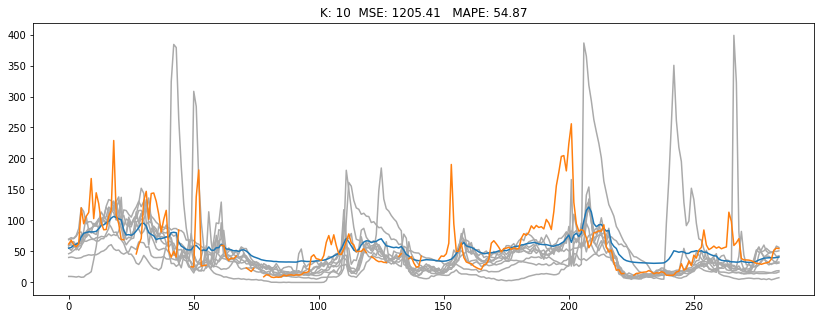

In [21]:
plt.figure(figsize=(14, 5))
for ii in range(5, 10):
    plt.subplot(5, 1, ii-)
    knearest(ii)